# 1_EDA_Superstore — EDA Final Corregido 🧪

Este notebook forma parte del proyecto **ML CDA — Segmentación y Predicción de Churn**.

En este EDA vamos a:

- Cargar los datos usando la **clase `DataOverview`**.
- Entender la estructura y las variables originales del dataset.
- Crear variables de comportamiento clave:
  - `MntTotal` (gasto total histórico)
  - `TotalPurchases` (total de compras)
  - `CustomerTenure` (antigüedad)
  - `Perc_WebPurchases`, `Perc_CatalogPurchases`, `Perc_StorePurchases` (mezcla de canales)
- Analizar distribuciones y relaciones importantes (especialmente ligadas al **CLV**).
- Definir una etiqueta preliminar de **Churn** usando **K-Means sobre `Recency`**.
- Visualizar cómo se comporta Churn respecto al gasto total y la frecuencia de compra.

> 🔐 Importante: Si usamos esta definición de `Churn` como etiqueta en modelos supervisados,  
> **no utilizaremos `Recency` ni `RecencyCluster` como features**, para evitar tautologías.


## 1. Importación y carga de datos con `DataOverview`


In [16]:
import sys
from pathlib import Path

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# Añadimos la carpeta padre al path para poder importar utils
sys.path.append("..")

from utils.data_overview import DataOverview  # clase definida en utils/data_overview.py

sns.set(style="whitegrid")
pd.set_option("display.max_columns", None)

# Ruta del dataset (este notebook está en /notebooks)
data_path = Path("../data/superstore_data.csv")
print("📂 Usando archivo de datos en:", data_path)

df = pd.read_csv(data_path)

visor = DataOverview(df)
visor.resumen()
visor.categorias_unicas()
visor.resumen_numericas()


📂 Usando archivo de datos en: ..\data\superstore_data.csv
📊 Dimensiones: (2240, 22)

🧩 Tipos de datos:
int64      18
object      3
float64     1
Name: count, dtype: int64

🚫 Nulos por columna (top 10):
Income            24
Id                 0
Year_Birth         0
Education          0
Marital_Status     0
Kidhome            0
Teenhome           0
Dt_Customer        0
Recency            0
MntWines           0
dtype: int64

📎 Duplicados: 0 filas duplicadas
🔠 Variables categóricas (primeros valores únicos):
- Education: ['Graduation' 'PhD' '2n Cycle' 'Master' 'Basic']
- Marital_Status: ['Divorced' 'Single' 'Married' 'Together' 'Widow']
- Dt_Customer: ['6/16/2014' '6/15/2014' '5/13/2014' '11/5/2014' '8/4/2014']


,count,mean,std,min,25%,50%,75%,max
Id,2240.0,5592.16,3246.66,0.0,2828.25,5458.5,8427.75,11191.0
Year_Birth,2240.0,1968.81,11.98,1893.0,1959.00,1970.0,1977.00,1996.0
Income,2216.0,52247.25,25173.08,1730.0,35303.00,51381.5,68522.00,666666.0
Kidhome,2240.0,0.44,0.54,0.0,0.00,0.0,1.00,2.0
Teenhome,2240.0,0.51,0.54,0.0,0.00,0.0,1.00,2.0
Recency,2240.0,49.11,28.96,0.0,24.00,49.0,74.00,99.0
MntWines,2240.0,303.94,336.60,0.0,23.75,173.5,504.25,1493.0
MntFruits,2240.0,26.30,39.77,0.0,1.00,8.0,33.00,199.0
MntMeatProducts,2240.0,166.95,225.72,0.0,16.00,67.0,232.00,1725.0
MntFishProducts,2240.0,37.53,54.63,0.0,3.00,12.0,50.00,259.0


## 2. Explicación de las variables del dataset original

### 🧩 Variables demográficas
- **Id**: identificador único del cliente.  
- **Year_Birth**: año de nacimiento del cliente.  
- **Education**: nivel educativo.  
- **Marital_Status**: estado civil.  
- **Income**: ingreso anual del hogar.  
- **Kidhome**: número de niños en el hogar.  
- **Teenhome**: número de adolescentes en el hogar.  

### 🛒 Actividad comercial y gasto
- **Dt_Customer**: fecha en la que el cliente fue registrado.  
- **Recency**: días desde la última compra registrada.  
- **MntWines**: gasto en vinos.  
- **MntFruits**: gasto en frutas.  
- **MntMeatProducts**: gasto en productos cárnicos.  
- **MntFishProducts**: gasto en pescado.  
- **MntSweetProducts**: gasto en productos dulces.  
- **MntGoldProds**: gasto en productos “gold” o premium.  

### 📦 Actividad por canal
- **NumDealsPurchases**: compras realizadas con descuentos/ofertas.  
- **NumWebPurchases**: compras realizadas a través de la web.  
- **NumCatalogPurchases**: compras realizadas por catálogo.  
- **NumStorePurchases**: compras realizadas en tienda física.  
- **NumWebVisitsMonth**: número de visitas a la web al mes.  

### 🙂 Otros comportamientos
- **Response**: indicó si respondió positivamente a la última campaña.  
- **Complain**: indicó si ha presentado una queja en los últimos dos años.


## 3. Ingeniería de variables de comportamiento


### 3.1 ¿Por qué creamos estas variables?

En el dataset original tenemos mucha información granular, pero **no toda está en el formato ideal** para hacer:

- análisis exploratorio,
- segmentación,
- y modelos de churn.

Por eso construimos variables de comportamiento más agregadas:

- **CustomerTenure**: mide **cuánto tiempo lleva el cliente** con la empresa.  
  Nos ayuda a ver si los clientes más antiguos se comportan distinto que los recientes.

- **MntTotal**: suma de todos los gastos (`MntWines`, `MntFruits`, etc.).  
  Es una aproximación directa del **valor monetario acumulado** del cliente.

- **TotalPurchases**: suma de todas las compras (`NumWebPurchases`, `NumCatalogPurchases`, `NumStorePurchases`, `NumDealsPurchases`).  
  Captura con qué **frecuencia** el cliente interactúa comprando.

- **Perc_WebPurchases / Perc_CatalogPurchases / Perc_StorePurchases**:  
  proporciones de compras por canal. Dan una imagen clara de la **preferencia de canal**, útil para segmentación y para acciones de marketing.

Estas variables forman la base de un esquema tipo **RFM + ChannelMix**, que es estándar en proyectos de Marketing Analytics y Churn.

In [17]:
# Conversión de fecha de cliente y cálculo de antigüedad (CustomerTenure)
df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"])
max_date = df["Dt_Customer"].max()
df["CustomerTenure"] = (max_date - df["Dt_Customer"]).dt.days

# Gasto total histórico (Monetary)
cols_mnt = [
    "MntWines",
    "MntFruits",
    "MntMeatProducts",
    "MntFishProducts",
    "MntSweetProducts",
    "MntGoldProds"
]
df["MntTotal"] = df[cols_mnt].sum(axis=1)

# Compras totales (Frequency)
cols_purchases = [
    "NumDealsPurchases",
    "NumWebPurchases",
    "NumCatalogPurchases",
    "NumStorePurchases"
]
df["TotalPurchases"] = df[cols_purchases].sum(axis=1)

# Mezcla de canales (ChannelMix) — evitamos división por 0
total = df["TotalPurchases"].replace(0, 1)

df["Perc_WebPurchases"] = df["NumWebPurchases"] / total
df["Perc_CatalogPurchases"] = df["NumCatalogPurchases"] / total
df["Perc_StorePurchases"] = df["NumStorePurchases"] / total

df[[
    "CustomerTenure", "MntTotal", "TotalPurchases",
    "Perc_WebPurchases", "Perc_CatalogPurchases", "Perc_StorePurchases"
]].head()


,CustomerTenure,MntTotal,TotalPurchases,Perc_WebPurchases,Perc_CatalogPurchases,Perc_StorePurchases
0,173,1190,15,0.266667,0.266667,0.400000
1,174,577,18,0.388889,0.166667,0.388889
2,207,251,11,0.272727,0.181818,0.454545
3,31,11,4,0.250000,0.000000,0.500000
4,124,91,8,0.375000,0.125000,0.250000


### 3.2 CLV exploratorio a partir de gasto y frecuencia

A partir de `MntTotal` (valor monetario total) y `TotalPurchases` (frecuencia), construimos dos proxies de **Customer Lifetime Value (CLV)**:

- `CLV_simple` = `MntTotal` × `TotalPurchases`  
  - Representa el valor total aproximado generado por el cliente.  
  - Es muy sensible a outliers (clientes extremadamente valiosos).

- `CLV_log` = `log(1 + MntTotal)` × `log(1 + TotalPurchases)`  
  - Reduce el impacto de valores extremos.  
  - Suele ser más estable para análisis estadístico y modelos.

No son CLV “financieros perfectos”, pero sí **indicadores muy útiles** para:

- detectar segmentos de valor (bajo, medio, alto),
- analizar qué tipo de cliente tiende a entrar en churn,
- alimentar modelos de segmentación y predicción.

In [18]:
# CLV exploratorio
df["CLV_simple"] = df["MntTotal"] * df["TotalPurchases"]
df["CLV_log"] = np.log1p(df["MntTotal"]) * np.log1p(df["TotalPurchases"])

df[["MntTotal", "TotalPurchases", "CLV_simple", "CLV_log"]].head()

,MntTotal,TotalPurchases,CLV_simple,CLV_log
0,1190,15,17850,19.636994
1,577,18,10386,18.725377
2,251,11,2761,13.740115
3,11,4,44,3.999303
4,91,8,728,9.935385


## 4. Distribuciones de variables clave


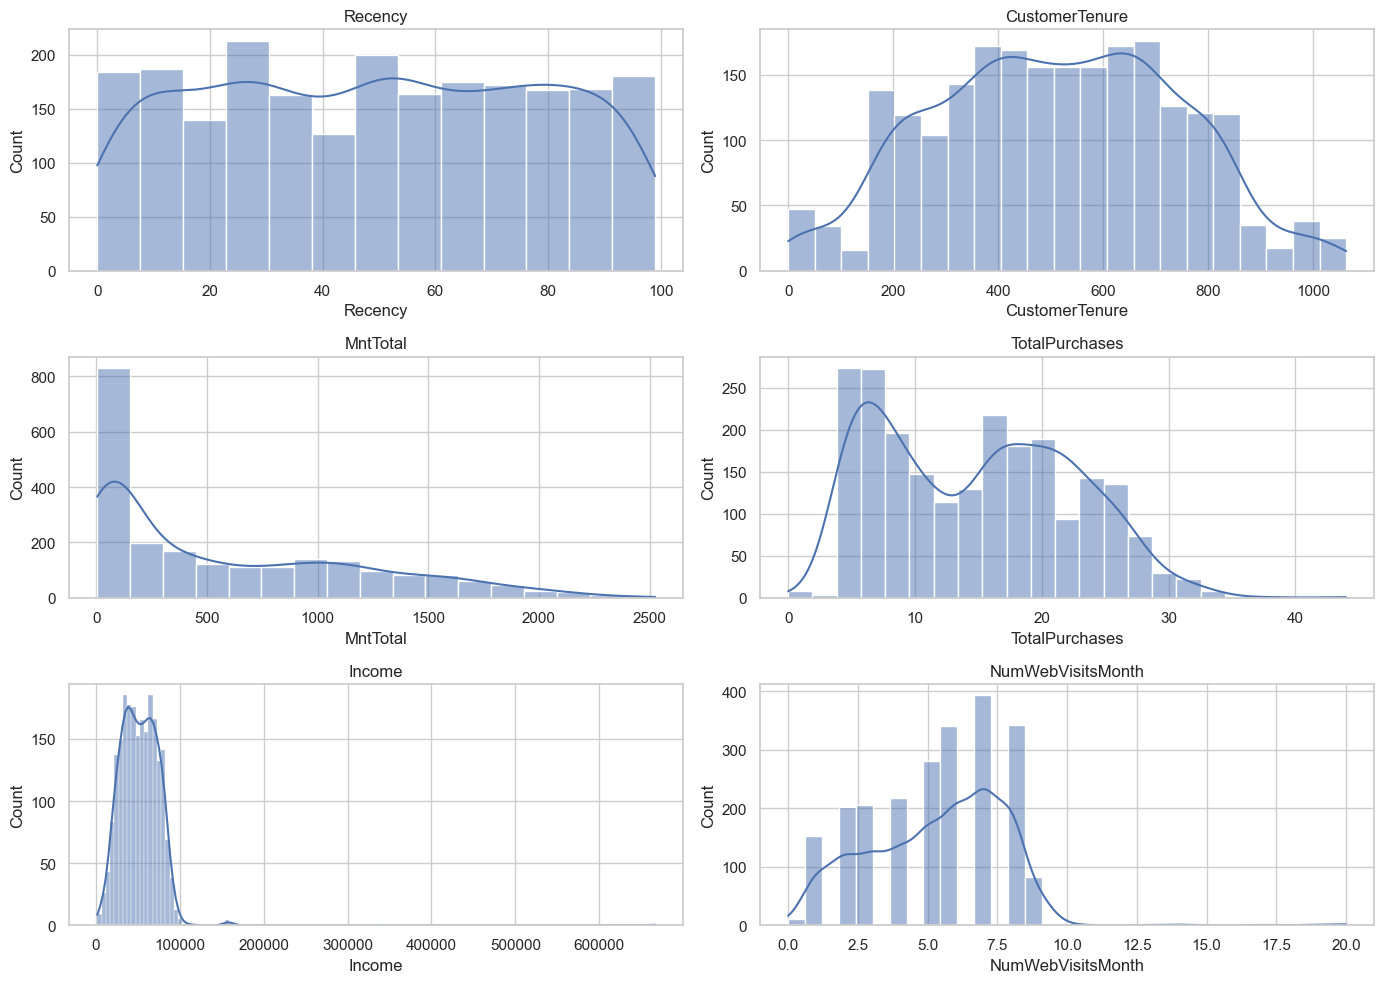

In [19]:
vars_hist = [
    "Recency",
    "CustomerTenure",
    "MntTotal",
    "TotalPurchases",
    "Income",
    "NumWebVisitsMonth"
]

plt.figure(figsize=(14, 10))
for i, col in enumerate(vars_hist, 1):
    plt.subplot(3, 2, i)
    sns.histplot(df[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()


## 5. Relación entre frecuencia de compra y gasto total (indicios de CLV)


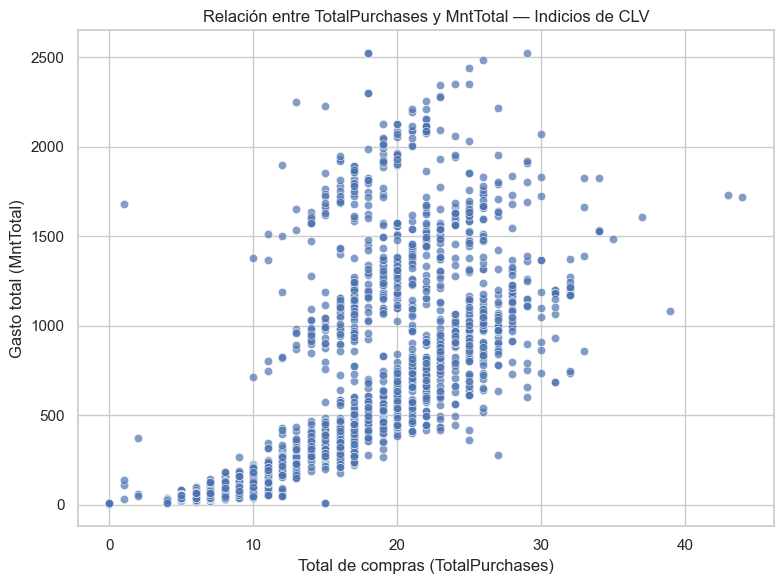

In [20]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x="TotalPurchases", y="MntTotal", data=df, alpha=0.7)
plt.title("Relación entre TotalPurchases y MntTotal — Indicios de CLV")
plt.xlabel("Total de compras (TotalPurchases)")
plt.ylabel("Gasto total (MntTotal)")
plt.tight_layout()
plt.show()


En esta nube de puntos se observan **tres grupos visuales claros**, aunque todavía no hemos aplicado ningún algoritmo de clustering:

1. Clientes con **pocas compras y bajo gasto** → bajo CLV.  
2. Clientes con **frecuencia y gasto intermedios** → CLV medio.  
3. Clientes con **muchas compras y gasto muy alto** → CLV alto.

Es decir, la relación entre `TotalPurchases` y `MntTotal` ya nos da una idea del  
**Customer Lifetime Value (CLV)** antes de aplicar modelos.


## 6. Análisis de mezcla de canales (`ChannelMix`)


In [21]:
channel_cols = ["Perc_WebPurchases", "Perc_CatalogPurchases", "Perc_StorePurchases"]
display(df[channel_cols].describe().T)


,count,mean,std,min,25%,50%,75%,max
Perc_WebPurchases,2240.0,0.266817,0.100210,0.0,0.200000,0.259259,0.333333,1.0
Perc_CatalogPurchases,2240.0,0.141742,0.127242,0.0,0.000000,0.120000,0.222222,1.0
Perc_StorePurchases,2240.0,0.409229,0.120772,0.0,0.333333,0.411765,0.500000,1.0


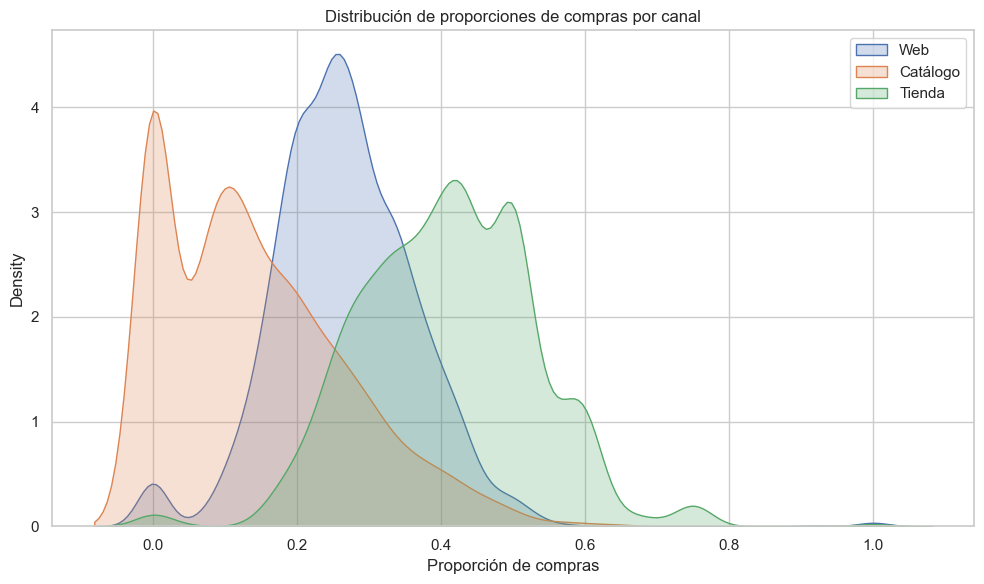

In [22]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x="Perc_WebPurchases", label="Web", fill=True)
sns.kdeplot(data=df, x="Perc_CatalogPurchases", label="Catálogo", fill=True)
sns.kdeplot(data=df, x="Perc_StorePurchases", label="Tienda", fill=True)
plt.title("Distribución de proporciones de compras por canal")
plt.xlabel("Proporción de compras")
plt.legend()
plt.tight_layout()
plt.show()


## 7. Variables categóricas: perfil demográfico


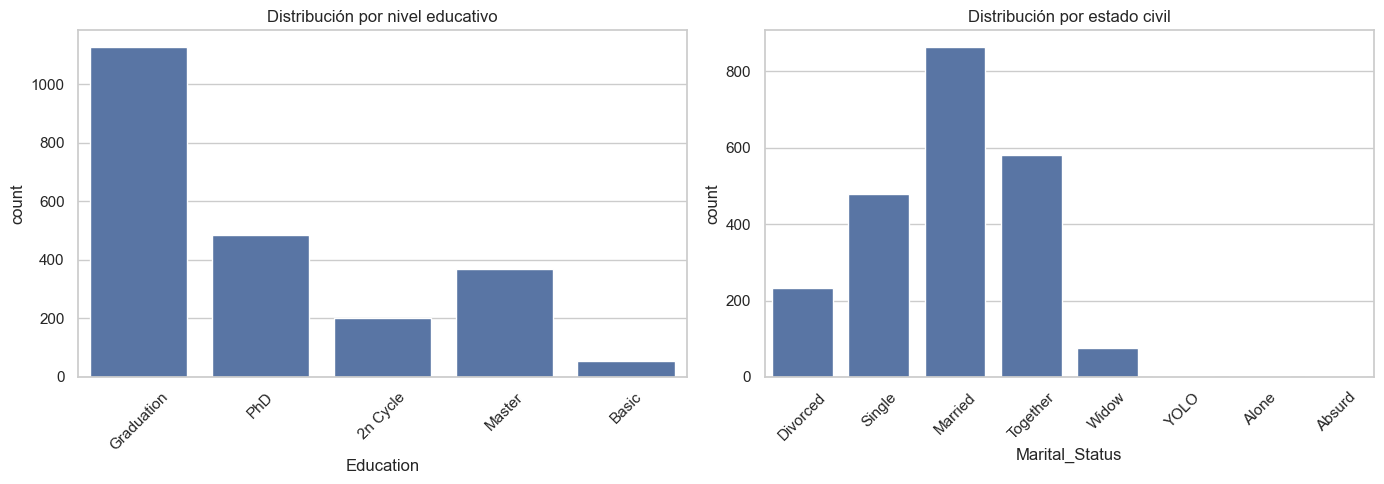

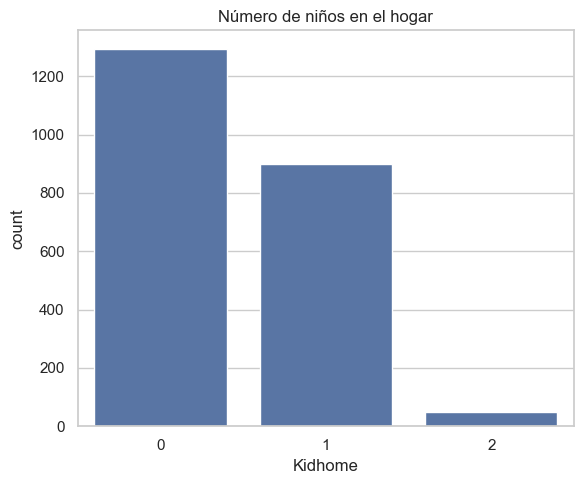

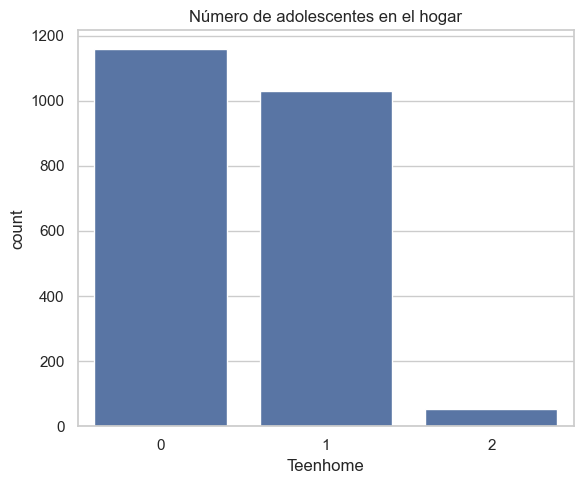

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.countplot(x="Education", data=df, ax=axes[0])
axes[0].set_title("Distribución por nivel educativo")
axes[0].tick_params(axis="x", rotation=45)

sns.countplot(x="Marital_Status", data=df, ax=axes[1])
axes[1].set_title("Distribución por estado civil")
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))
sns.countplot(x="Kidhome", data=df)
plt.title("Número de niños en el hogar")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))
sns.countplot(x="Teenhome", data=df)
plt.title("Número de adolescentes en el hogar")
plt.tight_layout()
plt.show()


## 8. Definición preliminar de `Churn` usando K-Means sobre `Recency`


Para definir una etiqueta preliminar de **Churn**:

1. Aplicamos **K-Means** usando solo la variable `Recency`.  
2. Obtenemos 4 clusters de clientes (`RecencyCluster`).  
3. Calculamos la **media de Recency** en cada cluster.  
4. El cluster con **mayor Recency promedio** se considera el grupo de clientes más inactivos.  
5. Definimos:
   - `Churn = 1` ⟶ cliente pertenece al cluster más inactivo.  
   - `Churn = 0` ⟶ cliente pertenece a cualquiera de los otros clusters.

> 📌 Regla importante: si usamos esta definición de `Churn` como etiqueta en modelos supervisados,  
> **no incluiremos `Recency` ni `RecencyCluster` como variables de entrada (features)**.


In [36]:
from sklearn.cluster import KMeans

# 8.1 Clustering K-Means sobre Recency
X_recency = df[["Recency"]]

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df["RecencyCluster"] = kmeans.fit_predict(X_recency)

# Media de Recency por cluster
cluster_means = df.groupby("RecencyCluster")["Recency"].mean()

# Cluster más inactivo (mayor Recency)
inactive_cluster = int(cluster_means.idxmax())

# Etiqueta de Churn
df["Churn"] = (df["RecencyCluster"] == inactive_cluster).astype(int)

print("🔹 Media de Recency por cluster:")
print(cluster_means, "\n")
print("🔹 Cluster considerado inactivo:", inactive_cluster)
print("\nDistribución de Churn (0=activo, 1=inactivo):")
print((df["Churn"].value_counts(normalize=True) * 100).round(2).astype(str) + "%")


🔹 Media de Recency por cluster:
RecencyCluster
0    82.935616
1    16.357692
2    50.278082
Name: Recency, dtype: float64 

🔹 Cluster considerado inactivo: 0

Distribución de Churn (0=activo, 1=inactivo):
Churn
0    67.41%
1    32.59%
Name: proportion, dtype: object


## 9. Visualización de Churn y relación con CLV


C:\Users\citma\AppData\Local\Temp\ipykernel_15328\181487962.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Churn", data=df, palette=["#66c2a5", "#fc8d62"])


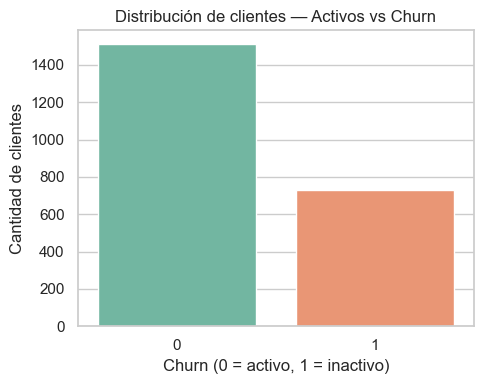

In [37]:
plt.figure(figsize=(5, 4))
sns.countplot(x="Churn", data=df, palette=["#66c2a5", "#fc8d62"])
plt.title("Distribución de clientes — Activos vs Churn")
plt.xlabel("Churn (0 = activo, 1 = inactivo)")
plt.ylabel("Cantidad de clientes")
plt.tight_layout()
plt.show()

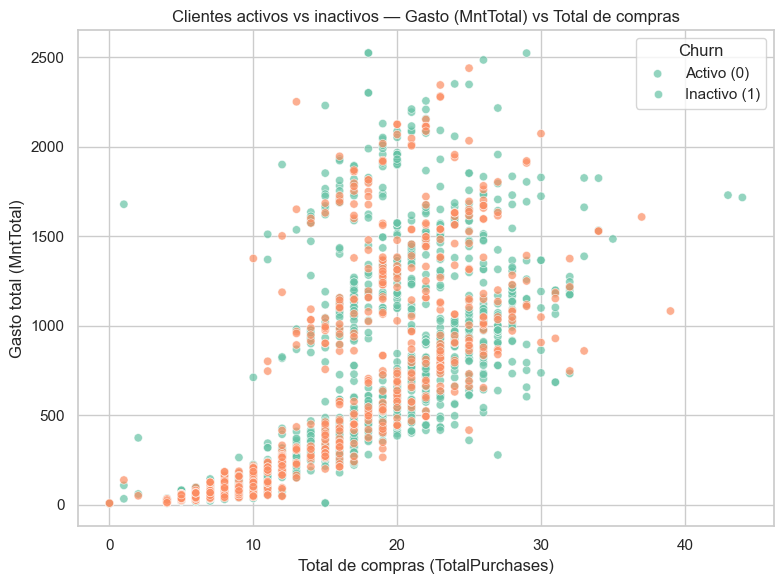

In [26]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x="TotalPurchases",
    y="MntTotal",
    hue="Churn",
    data=df,
    palette=["#66c2a5", "#fc8d62"],
    alpha=0.7
)
plt.title("Clientes activos vs inactivos — Gasto (MntTotal) vs Total de compras")
plt.xlabel("Total de compras (TotalPurchases)")
plt.ylabel("Gasto total (MntTotal)")
plt.legend(title="Churn", labels=["Activo (0)", "Inactivo (1)"])
plt.tight_layout()
plt.show()


En esta gráfica se aprecian claramente **tres grupos visuales**:

1. Pocas compras + poco gasto → **bajo CLV**.  
2. Compras y gasto intermedios → **CLV medio**.  
3. Muchas compras + mucho gasto → **CLV alto**.

Los clientes marcados como **Churn = 1** se concentran sobre todo en el grupo de **bajo CLV**,  
mientras que los clientes activos (`Churn = 0`) aparecen con más frecuencia en las zonas de **CLV medio y alto**.

Esto es coherente con la lógica de negocio:

> Los clientes de bajo valor son los que más tienden a abandonar;  
> los clientes con compras frecuentes y gasto alto tienden a permanecer activos.


## 10. Matriz de correlación de variables numéricas clave 🔗

Para cerrar el EDA, vemos cómo se relacionan entre sí las variables numéricas más importantes:

- `Recency` y `CustomerTenure` (dimensión temporal),
- `MntTotal` y `TotalPurchases` (valor y frecuencia),
- `Income` (capacidad adquisitiva),
- `NumWebVisitsMonth` (engagement digital),
- `CLV_log` (proxy de valor del cliente).

Esto nos ayuda a:

- detectar redundancias,
- entender si el CLV está alineado con gasto y frecuencia,
- ver si el tiempo como cliente está relacionado con valor o con riesgo de churn.

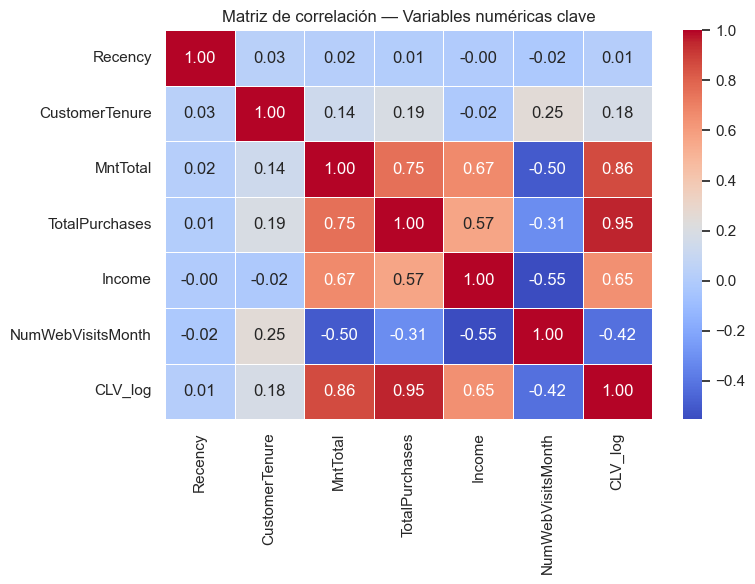

In [27]:
vars_corr = []
for col in ["Recency", "CustomerTenure", "MntTotal", "TotalPurchases", "Income", "NumWebVisitsMonth", "CLV_log"]:
    if col in df.columns:
        vars_corr.append(col)

if len(vars_corr) >= 2:
    corr = df[vars_corr].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, fmt=".2f", linewidths=0.5, cmap="coolwarm")
    plt.title("Matriz de correlación — Variables numéricas clave")
    plt.tight_layout()
    plt.show()
else:
    print("No hay suficientes variables numéricas para calcular la correlación.")

## 11. Exportación del dataset procesado 📁

Para asegurar que el **CDA, la segmentación y el modelo de churn** usen exactamente la misma versión de los datos, exportamos un dataset procesado con las variables clave de comportamiento y perfil del cliente.

Este archivo se guardará en `../data/superstore_procesado.csv`.

In [28]:
columnas_procesadas = []

candidatas = [
    # Identificadores / fechas
    "Id", "Dt_Customer",
    # RFM / comportamiento
    "Recency", "CustomerTenure", "MntTotal", "TotalPurchases",
    # ChannelMix
    "Perc_WebPurchases", "Perc_CatalogPurchases", "Perc_StorePurchases",
    # Perfil
    "Income", "Kidhome", "Teenhome",
    "Education", "Marital_Status",
    # Comportamiento online
    "NumWebVisitsMonth",
    # CLV
    "CLV_simple", "CLV_log"
]

for col in candidatas:
    if col in df.columns:
        columnas_procesadas.append(col)

df_procesado = df[columnas_procesadas].copy()
print("Columnas incluidas en el dataset procesado:")
print(columnas_procesadas)

output_path = "../data/superstore_procesado.csv"
df_procesado.to_csv(output_path, index=False)
print(f"✅ Dataset procesado guardado en: {output_path}")

Columnas incluidas en el dataset procesado:
['Id', 'Dt_Customer', 'Recency', 'CustomerTenure', 'MntTotal', 'TotalPurchases', 'Perc_WebPurchases', 'Perc_CatalogPurchases', 'Perc_StorePurchases', 'Income', 'Kidhome', 'Teenhome', 'Education', 'Marital_Status', 'NumWebVisitsMonth', 'CLV_simple', 'CLV_log']
✅ Dataset procesado guardado en: ../data/superstore_procesado.csv


# 📌 Conclusiones del EDA — Resumen Ejecutivo

### 1. Perfil del cliente
Los clientes son adultos, bien educados, con ingresos estables y pocos hijos.  
La base es homogénea y madura, lo que facilita modelar su comportamiento.

---

### 2. Comportamiento de compra
- **Gasto total (MntTotal)** altamente concentrado → pocos clientes generan la mayoría del valor.  
- **TotalPurchases** revela dos grupos naturales: clientes ocasionales y clientes frecuentes.  
- **Preferencia de canal:** Tienda > Web > Catálogo.

➡️ *Esto confirma que existen patrones claros para segmentación.*

---

### 3. Actividad temporal
- **Recency** está distribuido de forma uniforme → no distingue entre clientes valiosos o no.  
- **CustomerTenure** elevado → la mayoría son clientes antiguos.

---

### 4. Valor del cliente
El scatter entre gasto y frecuencia revela cuatro perfiles naturales  
(bajo, medio, alto valor y VIP).  
**CLV_log** sintetiza correctamente el valor del cliente.

---

### 5. Correlaciones clave
- CLV_log correlaciona fuertemente con MntTotal y TotalPurchases.  
- Recency tiene correlación casi nula con valor.

➡️ *Recency NO predice valor ni comportamiento importante.*

---

### 6. Por qué NO usar el churn original
El churn basado solo en Recency no separa a los clientes:  
los “activos” e “inactivos” aparecen mezclados en todos los niveles de gasto y frecuencia.  
No refleja abandono real.

---

## ⭐ Por qué crearemos **Churn Valioso**
Para construir un modelo útil necesitamos un churn que:
- represente **inactividad real**,  
- distinga clientes según su **valor para la empresa**,  
- sea **coherente con los patrones encontrados en el EDA**,  
- y tenga sentido para un modelo supervisado.

Un **Churn Valioso** permitirá conectar el comportamiento real del cliente  
con el CDA, la segmentación y el modelo final de predicción.

---
